# Кузин Мирослав гр.4.6 вариант 37

**N,Студент,первый_слой,второй_слой,градиент**

**32,Кузин Мирослав,Гиперболический тангенс,Гиперболический тангенс,Adam**

In [290]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from keras.utils import to_categorical
from keras import models
from keras import layers
import tqdm

In [291]:
np.random.seed(0)

**Функции активации**

*Сигмоида*

In [292]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_diff(x):
    return sigmoid(x)*(1-sigmoid(x))

*Th*

In [293]:
def th(x):
    exp_x = np.exp(x)
    exp_dis_x= np.exp(-x)
    return (exp_x-exp_dis_x)/(exp_x+exp_dis_x)

def th_diff(x):
    return 1 - np.square(th(x))

*Softsign*

In [294]:
def softsign(x):
    return x/(1+np.abs(x))

def softsign_diff(x):
    return 1/(1+np.abs(x))**2

*Relu*

In [295]:
def relu(x):
    x[x<0] = 0
    return x

def relu_diff(x):
    x[x>=0] = 1
    x[x<0] = 0
    return x

In [296]:
def prelu(x, a = 1):
    x[x<=0] = a * x[x<0]
    return x

def prelu_diff(x, a = 1):
    x[x>=0] = 1
    x[x<0] = a
    return x

*ELU*

In [297]:
def elu(x, a = 1):
    x[x<=0] = a * (np.exp(x[x<0])-1)
    return x

def elu_diff(x, a = 1):
    x[x>=0] = 1
    x[x<=0] = elu(x[x<=0], a) + a
    return x

*Linear function*

In [298]:
def linear(weight_l, input_l, bias):
    return np.dot(weight_l, input_l) + bias

**Нейросеть**

$$U = U_{1,s} = \left( u_1,\ u_2,\dots,u_k\right)  = \left( \dots u_i\dots\right)_{1\times s} $$
$$V = V_{s,k} = 
\left(
  \begin{array}{ccc}
  v_{11} & \cdots & v_{1k} \\
  v_{21} & \cdots & v_{2k} \\
  \cdots & \cdots & \cdots \\
  v_{s1} & \cdots & v_{sk} \\
  \end{array}
  \right) = 
\left(
  \begin{array}{ccc}
  \cdots & \cdots & \cdots \\
  \cdots & v_{ij} & \cdots \\
  \cdots & \cdots & \cdots \\
  \end{array}
  \right)_{s\times k}
   $$

$$W = W_{k,n} = 
\left(
  \begin{array}{ccc}
  w_{11} & \cdots & w_{1n} \\
  w_{21} & \cdots & w_{2n} \\
  \cdots & \cdots & \cdots \\
  w_{k1} & \cdots & w_{kn} \\
  \end{array}
  \right) = 
\left(
  \begin{array}{ccc}
  \cdots & \cdots & \cdots \\
  \cdots & w_{ij} & \cdots \\
  \cdots & \cdots & \cdots \\
  \end{array}
  \right)_{k\times n}
   $$

$$X = X_{n,m} = 
\left(
  \begin{array}{ccc}
  x_{11} & \cdots & x_{1n} \\
  x_{21} & \cdots & x_{2n} \\
  \cdots & \cdots & \cdots \\
  x_{n1} & \cdots & x_{nm} \\
  \end{array}
  \right) = 
\left(
  \begin{array}{ccc}
  \cdots & \cdots & \cdots \\
  \cdots & x_{ij} & \cdots \\
  \cdots & \cdots & \cdots \\
  \end{array}
  \right)_{n\times m}
   $$

$$ X_{i} = 
\left(
  \begin{array}{c}
   x_{1i} \\
   x_{2i} \\
   \cdots \\
   x_{ni} \\
  \end{array}
  \right) 
   $$

 $$ B = B_{k,1} = 
\left(
  \begin{array}{c}
   b_{1} \\
   b_{2} \\
   \cdots \\
   b_{k} \\
  \end{array}
  \right) 
   $$ 

 $$ C = C_{s,1} = 
\left(
  \begin{array}{c}
   c_{1} \\
   c_{2} \\
   \cdots \\
   c_{s} \\
  \end{array}
  \right) 
   $$ 


$$\phi(W\cdot X+B)=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & \phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

$$V\cdot\phi(W\cdot X+B)=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & \sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

$$V\cdot\phi(W\cdot X+B) + C=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & \sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r  & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

$$\psi (V\cdot\phi(W\cdot X+B) + C)=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & \psi\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right)  & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

$$U\psi (V\cdot\phi(W\cdot X+B) + C)=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & u_r\psi\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right)  & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

$$NN(X) = U\psi (V\cdot\phi(W\cdot X+B) + C) + d=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & u_r\psi\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right) + d  & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$


$$L(X_p) = \sum\limits_{p=1}^{m}(y_p-NN(X_p))^2 $$

$$ \dfrac{\partial L}{\partial u_{r}}= -2 \sum\limits_{p=1}^{m}(y_p-NN(X_p))  \psi\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right) $$


$$ \dfrac{\partial L}{\partial v_{ri}}= -2 \sum\limits_{p=1}^{m}(y_p-NN(X_p))  u_r\psi'\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right)\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) $$


$$ \dfrac{\partial L}{\partial w_{il}}= -2 \sum\limits_{p=1}^{m}(y_p-NN(X_p))  u_r\psi'\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right)v_{ri}\phi'\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right)x_{lp}$$

$$ \dfrac{\partial L}{\partial c_{r}}= -2 \sum\limits_{p=1}^{m}(y_p-NN(X_p))  u_r\psi'\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right) $$

$$ \dfrac{\partial L}{\partial b_{i}}= -2 \sum\limits_{p=1}^{m}(y_p-NN(X_p))  u_r\psi'\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right)v_{ri}\phi'\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right)$$

$$ \dfrac{\partial L}{\partial d}= -2 \sum\limits_{p=1}^{m}(y_p-NN(X_p))$$

$$ \dfrac{\partial L}{\partial U_{1,s}}= -2 (Y_{1,m} - NN(X_{n,m})) \cdot  \psi (V_{s,k}\cdot\phi(W_{k,n}\cdot X_{n,m} + B_{k,1}) + C_{s,1}) ^{\tau}$$

$$ \dfrac{\partial L}{\partial V_{s,k}}= -2U_{1,s} ^{\tau}(( (Y_{1,m} - NN(X_{n,m}))   \psi' (V_{s,k}\cdot\phi(W_{k,n}\cdot X_{n,m} + B_{k,1}) + C_{s,1}))\cdot\phi(W_{k,n}\cdot X_{n,m} + B_{k,1}) ^{\tau})$$


$$ \dfrac{\partial L}{\partial W_{k,n}}=  -2(((U_{1,s}V_{s,k}^{\tau}) \cdot ( (Y_{1,m} - NN(X_{n,m}))   \psi' (V_{s,k}\cdot\phi(W_{k,n}\cdot X_{n,m} + B_{k,1}) + C_{s,1}) ))\phi'(W_{k,n}\cdot X_{n,m} + B_{k,1})))\cdot X_{n,m} ^{\tau}$$

$$ \dfrac{\partial L}{\partial B_{k,1}}=   -2(((U_{1,s}V_{s,k}^{\tau}) \cdot (    \psi' (V_{s,k}\cdot\phi(W_{k,n}\cdot X_{n,m} + B_{k,1}) + C_{s,1}) ))\phi'(W_{k,n}\cdot X_{n,m} + B_{k,1})))\cdot (Y_{1,m} - NN(X_{n,m})) ^{\tau}$$

$$ \dfrac{\partial L}{\partial C_{s,1}}=  -2U_{1,s}^{\tau}  (\psi' (V_{s,k}\cdot\phi(W_{k,n}\cdot X_{n,m} + B_{k,1}) + C_{s,1})\cdot ((Y_{1,m} - NN(X_{n,m}))^{\tau} )  $$



In [299]:
from types import FunctionType

class NeuralNetwork:

    act_f_diff: FunctionType

    # Для Adagrad
    g_w1_l, g_w2_l, g_w3_l, g_b1_l, g_b2_l, g_b3_l = (0, 0, 0, 0, 0, 0)

    # Для Adam
    m_w1, m_w2, m_w3, m_b1, m_b2, m_b3 = (0, 0, 0, 0, 0, 0)
    v_w1, v_w2, v_w3, v_b1, v_b2, v_b3 = (0, 0, 0, 0, 0, 0)

    def __init__(self, x, y, n1 = 5, n2 = 5, act_f = th): # x - исходные значения (датасет), y - target значения
        self.input = x # входные данные
        self.target = y # целевые(выходные) значения
        self.n_hidden_neurons_1 = n1 # кол-во нейронов в 1 слое
        self.n_hidden_neurons_2 = n2 # кол-во нейронов в 2 слое
        self.act_f = act_f # функция активации

        # Инициализируем производную функции активации
        if act_f == sigmoid:
            self.act_f_diff = sigmoid_diff
        elif act_f == th:
            self.act_f_diff = th_diff
        elif act_f == softsign:
            self.act_f_diff = softsign_diff
        elif act_f == relu:
            self.act_f_diff = relu_diff
        elif act_f == prelu:
            self.act_f_diff = prelu_diff
        elif act_f == elu:
            self.act_f_diff = elu_diff
        else:
            raise("Это не функция активации!")

        # Функции линейных слоев
        self.fc1 = linear
        self.bias1 = np.random.rand(self.n_hidden_neurons_1, 1)*0.99+0.01
        self.fc2 = linear
        self.bias2 = np.random.rand(self.n_hidden_neurons_2, 1)*0.99+0.01
        self.fc3 = linear
        self.bias3 = np.random.rand()*0.99+0.01

        # Инициализируем веса и выходные значения рандомными числами
        self.weights1 = np.random.rand(self.n_hidden_neurons_1, self.input.shape[0])*0.99+0.01
        self.weights2 = np.random.rand(self.n_hidden_neurons_2, self.n_hidden_neurons_1)*0.99+0.01
        self.weights3 = np.random.rand(1, self.n_hidden_neurons_2)*0.99+0.01
        self.output = np.zeros(self.target.shape)

        # # Обновляем сумму градиентов
        # self.g_w1_l = np.zeros(self.weights1.shape)
        # self.g_w2_l = np.zeros(self.weights2.shape)
        # self.g_b1_l = np.zeros(self.bias1.shape)
        # self.g_b2_l = 0

        # self.m_w1, self.m_w2, self.m_b1, self.m_b2 = np.zeros((4, n, 1))
        # self.v_w1, self.v_w2, self.v_b1, self.v_b2 = np.zeros((4, n, 1))

    def forward(self, x, y = None):
        self.input = x
        if y is not None:
            self.target = y
        self.layer1 = self.fc1(self.weights1, self.input, self.bias1)
        self.act_f1 = self.act_f(self.layer1)
        self.layer2 = self.fc2(self.weights2, self.act_f1, self.bias2)
        self.act_f2 = self.act_f(self.layer2)
        self.output = self.fc3(self.weights3, self.act_f2, self.bias3)
        return self.output

    def backprop(self, epoch=1, grad = 'SGD', alpha = None):
        if alpha == None:
            if grad == 'Adam':
                self.adam(self.input, epoch=epoch)
            elif grad == 'SGD':
                self.sgd(self.input)
            elif grad == 'Adagrad':
                self.adagrad(self.input)
        else:
            if grad == 'Adam':
                self.adam(self.input, epoch=epoch, a = alpha)
            elif grad == 'SGD':
                self.sgd(self.input, a = alpha)
            elif grad == 'Adagrad':
                self.adagrad(self.input, a = alpha)

    # Градиентные шаги
    def sgd(self, x, a = 0.01):

        d_weights3 = 2*np.dot((self.target - self.output), self.act_f2.T)
        d_weights2 = 2*self.weights3.T * np.dot((self.target - self.output) * self.act_f_diff(self.layer2), self.act_f1.T)
        d_weights1 = 2*np.dot(np.dot(self.weights3*self.weights2.T, (self.target - self.output) * self.act_f_diff(self.layer2))*self.act_f_diff(self.layer1), self.input.T)

        d_bias3    = 2*(self.target - self.output).sum()
        d_bias2    = 2*self.weights3.T*np.dot(self.act_f_diff(self.layer2), (self.target - self.output).T)
        d_bias1    = 2*np.dot(np.dot(self.weights3*self.weights2.T,self.act_f_diff(self.layer2))*self.act_f_diff(self.layer1), (self.target - self.output).T)

        self.weights1 += a * d_weights1
        self.weights2 += a * d_weights2
        self.weights3 += a * d_weights3
        self.bias1    += a * d_bias1
        self.bias2    += a * d_bias2
        self.bias3    += a * d_bias3

    # Адаптивный градиентный спуск
    def adagrad(self, x, a = 1.0e-1, eps = 1.0e-5):

        # Градиенты
        d_weights3 = 2*np.dot((self.target - self.output), self.act_f2.T)
        d_weights2 = 2*self.weights3.T * np.dot((self.target - self.output) * self.act_f_diff(self.layer2), self.act_f1.T)
        d_weights1 = 2*np.dot(np.dot(self.weights3*self.weights2.T, (self.target - self.output) * self.act_f_diff(self.layer2))*self.act_f_diff(self.layer1), self.input.T)

        d_bias3    = 2*(self.target - self.output).sum()
        d_bias2    = 2*self.weights3.T*np.dot(self.act_f_diff(self.layer2), (self.target - self.output).T)
        d_bias1    = 2*np.dot(np.dot(self.weights3*self.weights2.T,self.act_f_diff(self.layer2))*self.act_f_diff(self.layer1), (self.target - self.output).T)
        #  2*np.dot(np.dot(self.weights3*self.weights2.T,sigmoid_diff(self.layer2))*sigmoid_diff(self.layer1), (self.y - self.output).T)

        # lr_s = lr/(1+(epoch-1))

        # Обновляем сумму градиентов
        self.g_w1_l += np.square(d_weights1)
        self.g_w2_l += np.square(d_weights2)
        self.g_w3_l += np.square(d_weights3)
        self.g_b1_l += np.square(d_bias1)
        self.g_b2_l += np.square(d_bias2)
        self.g_b3_l += np.square(d_bias3)

        self.weights1 += a * d_weights1 / np.sqrt(self.g_w1_l + eps)
        self.weights2 += a * d_weights2 / np.sqrt(self.g_w2_l + eps)
        self.weights3 += a * d_weights3 / np.sqrt(self.g_w3_l + eps)
        self.bias1 += a * d_bias1 / (np.sqrt(self.g_b1_l) + eps)
        self.bias2 += a * d_bias2 / (np.sqrt(self.g_b2_l) + eps)
        self.bias3 += a * d_bias3 / (np.sqrt(self.g_b3_l) + eps)

    # Adam
    def adam(self, x, epoch, a = 1.0e-3, beta1 = 0.9, beta2 = 0.9, eps = 1.0e-5):

        # Градиенты
        d_weights3 = 2*np.dot((self.target - self.output), self.act_f2.T)
        d_weights2 = 2*self.weights3.T * np.dot((self.target - self.output) * self.act_f_diff(self.layer2), self.act_f1.T)
        d_weights1 = 2*np.dot(np.dot(self.weights3*self.weights2.T, (self.target - self.output) * self.act_f_diff(self.layer2))*self.act_f_diff(self.layer1), self.input.T)

        d_bias3    = 2*(self.target - self.output).sum()
        d_bias2    = 2*self.weights3.T*np.dot(self.act_f_diff(self.layer2), (self.target - self.output).T)
        d_bias1    = 2*np.dot(np.dot(self.weights3*self.weights2.T,self.act_f_diff(self.layer2))*self.act_f_diff(self.layer1), (self.target - self.output).T)

        # Обновляем основу первого и второго моментов импульсов
        self.m_w1, self.m_w2, self.m_w3, self.m_b1, self.m_b2, self.m_b3 = list(map(lambda grad, m: (1-beta1)*grad+beta1*m ,(d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3), (self.m_w1, self.m_w2, self.m_w3, self.m_b1, self.m_b2, self.m_b3)))
        m_corrected_w1, m_corrected_w2, m_corrected_w3, m_corrected_b1, m_corrected_b2, m_corrected_b3  = list(map(lambda m: m / (1-np.power(beta1, epoch)),(self.m_w1, self.m_w2, self.m_w3, self.m_b1, self.m_b2, self.m_b3)))

        self.v_w1, self.v_w2, self.v_w3, self.v_b1, self.v_b2, self.v_b3 = list(map(lambda grad, v: (1-beta2)*grad**2+beta2*v,(d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3), (self.v_w1, self.v_w2, self.v_w3, self.v_b1, self.v_b2, self.v_b3)))
        v_corrected_w1, v_corrected_w2, v_corrected_w3, v_corrected_b1, v_corrected_b2, v_corrected_b3 = list(map(lambda v: v/ (1-np.power(beta2, epoch)),(self.v_w1, self.v_w2, self.v_w3, self.v_b1, self.v_b2, self.v_b3)))

        self.weights1 += a*m_corrected_w1 / (np.sqrt(v_corrected_w1) + eps)
        self.weights2 += a*m_corrected_w2 / (np.sqrt(v_corrected_w2) + eps)
        self.weights3 += a*m_corrected_w3 / (np.sqrt(v_corrected_w3) + eps)
        self.bias1 += a*m_corrected_b1 / (np.sqrt(v_corrected_b1) + eps)
        self.bias2 += a*m_corrected_b2 / (np.sqrt(v_corrected_b2) + eps)
        self.bias3 += a*m_corrected_b3 / (np.sqrt(v_corrected_b3) + eps)

*Loss-функция*

In [300]:
def loss(pred, target):
    squares = ((pred - target) ** 2)**(0.5)
    return squares.mean()

$$U = U_{1,k} = \left( u_1,\ u_2,\dots,u_k\right)  = \left( \dots u_i\dots\right)_{1\times k} $$

$$W = W_{k,n} = 
\left(
  \begin{array}{ccc}
  w_{11} & \cdots & w_{1n} \\
  w_{21} & \cdots & w_{2n} \\
  \cdots & \cdots & \cdots \\
  w_{k1} & \cdots & w_{kn} \\
  \end{array}
  \right) = 
\left(
  \begin{array}{ccc}
  \cdots & \cdots & \cdots \\
  \cdots & w_{ij} & \cdots \\
  \cdots & \cdots & \cdots \\
  \end{array}
  \right)_{k\times n}
   $$

$$X = X_{n,m} = 
\left(
  \begin{array}{ccc}
  x_{11} & \cdots & x_{1n} \\
  x_{21} & \cdots & x_{2n} \\
  \cdots & \cdots & \cdots \\
  x_{n1} & \cdots & x_{nm} \\
  \end{array}
  \right) = 
\left(
  \begin{array}{ccc}
  \cdots & \cdots & \cdots \\
  \cdots & x_{ij} & \cdots \\
  \cdots & \cdots & \cdots \\
  \end{array}
  \right)_{n\times m}
   $$

$$ X_{i} = 
\left(
  \begin{array}{c}
   x_{1i} \\
   x_{2i} \\
   \cdots \\
   x_{ni} \\
  \end{array}
  \right) 
   $$

 $$ B = B_{k,1} = 
\left(
  \begin{array}{c}
   b_{1} \\
   b_{2} \\
   \cdots \\
   b_{k} \\
  \end{array}
  \right) 
   $$ 


**Проверим нейросеть на моделировании двумерного графика**

In [301]:
def f(x):
    return x**2

X = np.array([np.arange(-1, 1.1, 0.1)])
Y = f(X)
#Y += 0.1*(np.random.random(Y.shape) - 0.5)
z = NeuralNetwork(X,Y, act_f = sigmoid)
# z.weights1

In [302]:
order = np.random.permutation(X.shape[1]) # Перемешиваем значения на входе
batch_size = 5 # Размер батча

for i in np.arange(1, 10000):

    for start_index in range(0, X.shape[1], batch_size):
        batch_indexes = order[start_index:start_index+batch_size]

        x_train = X[:,batch_indexes]
        y_train = Y[:,batch_indexes]

        z_pred = z.forward(x_train, y_train)
        z.backprop(epoch=i, grad='SGD')

    z_pred = z.forward(X,Y)

    if i %1000 == 0:
        print("Loss = ", loss(z_pred, Y))

Loss =  0.2913293291327569
Loss =  0.2870739763946193
Loss =  0.28087462351886416
Loss =  0.2579663859071235
Loss =  0.08115331114085113
Loss =  0.049052714040717746
Loss =  0.034845087664672446
Loss =  0.02580828459948036
Loss =  0.01976992961140723


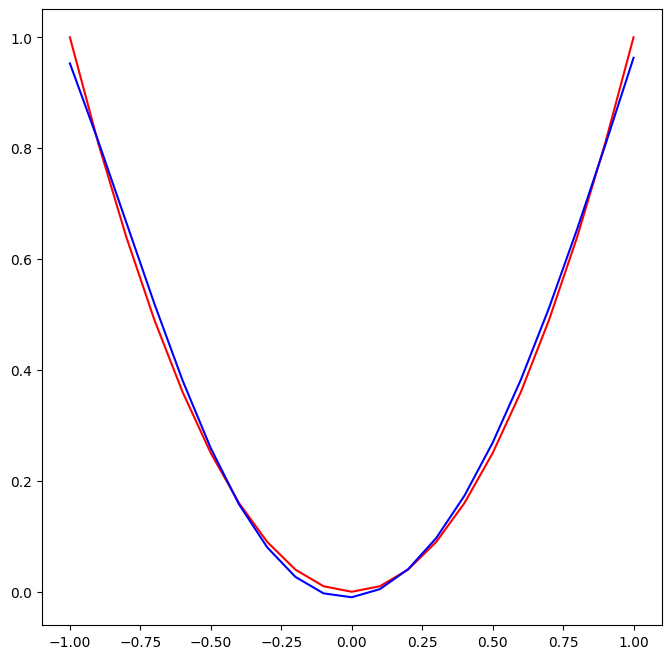

In [303]:
plt.figure(figsize=(8, 8))
plt.rcParams.update({'figure.figsize': (5, 5)})
X_n = np.arange(-1, 1.1, 0.1)
F = f(X_n)
#print(X[0],F)
Y_n = z.forward(np.array([X_n]))
plt.plot(X_n,F,color='r')
plt.plot(X_n.ravel(),Y_n.ravel(),color='b')

37. $f(x, y) = \dfrac{1}{|x|+ 4} + \dfrac{3}{y2+ 4}$

In [304]:
def f(x, y):
    return 1/(abs(x) + 4) + 3/(y**2+4)

Text(0.5, 0, 'z')

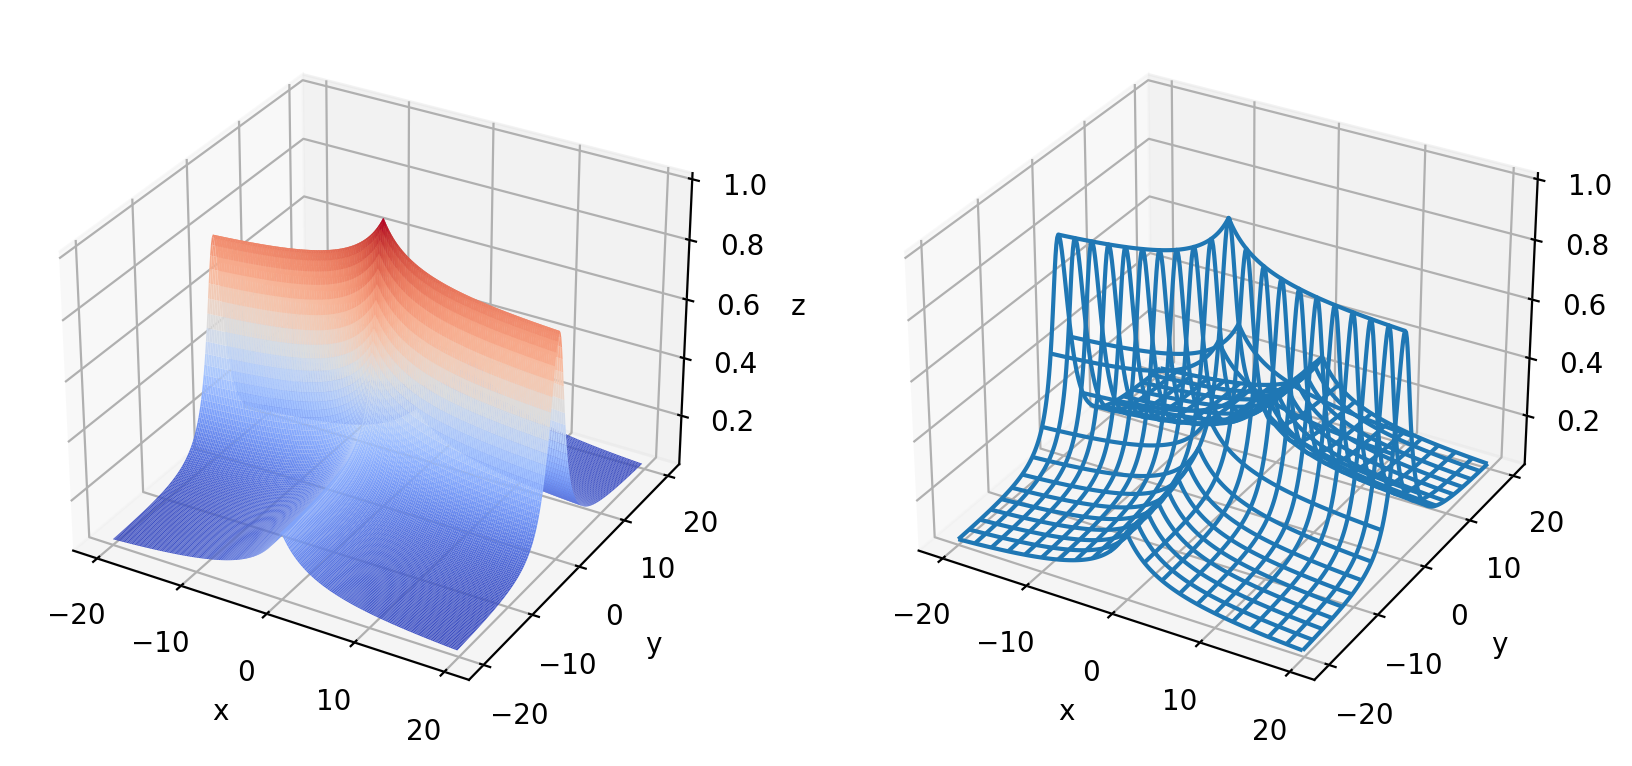

In [305]:
fig = plt.figure(figsize=plt.figaspect(0.5), dpi=200)

ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-20, 20, 0.2)
Y = np.arange(-20, 20, 0.2)
X, Y = np.meshgrid(X, Y)
Z = f(X,Y)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [306]:
dim_x = 100
X = np.arange(-20, 20.25, 0.2)
Y = np.arange(-20, 20.25, 0.2)
X, Y = np.meshgrid(X, Y)
print(X.shape, Y.shape, sep='\n') # проверим размерность входных данных
X1, Y1 = X.ravel(), Y.ravel() # приводим к одномерному массиву
Z1 = f(X1, Y1)

(202, 202)
(202, 202)


In [307]:
Xd = np.array([X1,Y1])
Xd.shape

(2, 40804)

In [308]:
Zd = np.array([list(Z1)])
Zd.shape

(1, 40804)

In [309]:
z = NeuralNetwork(Xd,Zd, n1=8, n2=11)
z.input.shape

(2, 40804)

In [310]:
order = np.random.permutation(Xd.shape[1]) # Перемешиваем значения на входе
batch_size = 100 # Размер батча


loss_start = 1
count = 0
while loss_start > 0.0009:
    count += 1

    for start_index in range(0, Xd.shape[1], batch_size):
        batch_indexes = order[start_index:start_index+batch_size]

        x_train = Xd[:,batch_indexes]
        z_train = Zd[:,batch_indexes]

        z_pred = z.forward(x_train, z_train)

        if count > 100:
            z.backprop(epoch=i, grad="Adam", alpha=1.0e-3)
        else:
            z.backprop(epoch=i, grad="Adam", alpha=1.0e-2)

    z_pred = z.forward(Xd,Zd)
    loss_start = loss(z_pred, Zd) # считаем Loss-функцию

    if count % 100 == 0:
        print(loss_start)

    # Выход, если точность упирается в потолок
    if count > 10000:
        break

0.008342719251520072


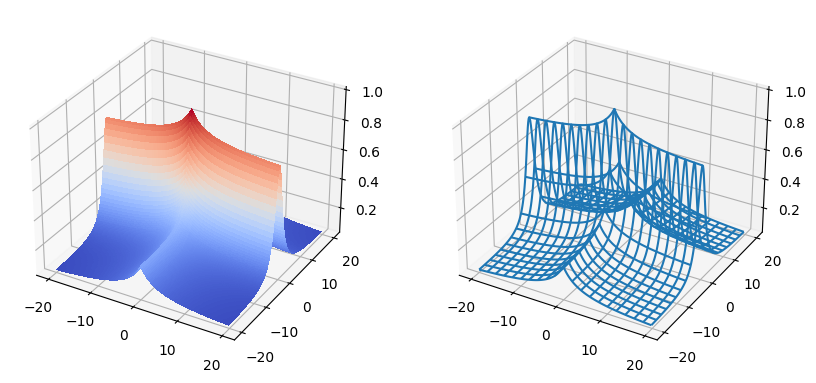

In [311]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-20, 20, 0.2)
Y = np.arange(-20, 20, 0.2)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)
#X, Y, Z = get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

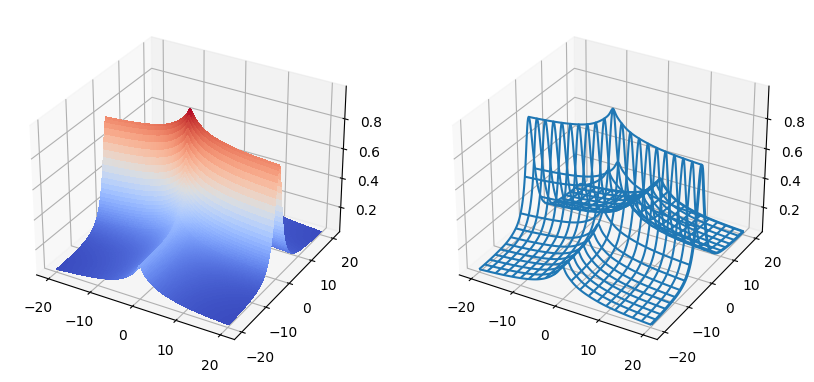

In [312]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-20, 20.25, 0.2)
Y = np.arange(-20, 20.25, 0.2)

# Z = z.test(np.array([X,Y]))
X, Y = np.meshgrid(X, Y)

Z = z.forward(np.array([X.ravel(),Y.ravel()])).reshape(202, 202)

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

**Сохранить модель в файл**

In [313]:
import pickle
with open("./models_lab2/model37_3.pkl", 'wb') as fp:
    pickle.dump(z, fp)

In [314]:
print(id(z))
with open("./models_lab2/model37_3.pkl", 'rb') as fp:
    z = pickle.load(fp)
print(id(z))

2671574299600
2671551393280


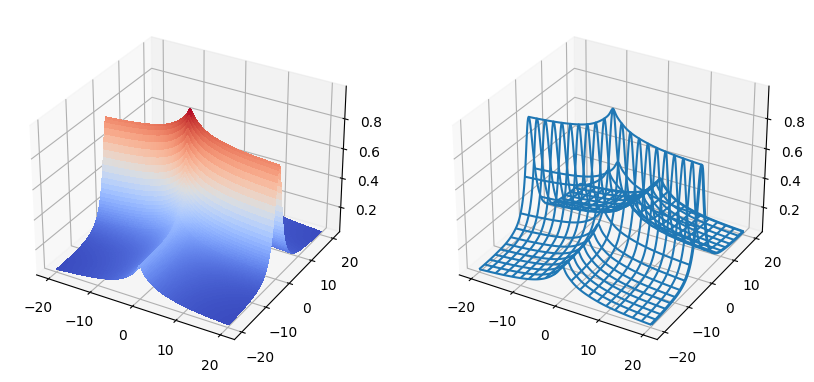

In [315]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-20, 20.25, 0.2)
Y = np.arange(-20, 20.25, 0.2)

# Z = z.test(np.array([X,Y]))
X, Y = np.meshgrid(X, Y)

Z = z.forward(np.array([X.ravel(),Y.ravel()])).reshape(202, 202)

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)